In [1]:
!pip install transformers
!pip install sentencepiece
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install simpletransformers

     |████████████████████████████████| 3.8 MB 9.0 MB/s 
     |████████████████████████████████| 895 kB 52.6 MB/s 
     |████████████████████████████████| 67 kB 7.2 MB/s 
     |████████████████████████████████| 596 kB 54.3 MB/s 
     |████████████████████████████████| 6.5 MB 52.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 7.4 MB/s 
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
     |████████████████████████████████| 248 kB 7.9 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 311 kB 63.0 MB/s 
     |████████████████████████████████| 9.9 MB 56.8 MB/s 
     |████████████████████████████████| 1.7 MB 41.3 MB/s 
     |████████████████████████████████| 144 kB 67.1 MB/s 
     |████████████████████████████████| 181 kB 73.8 MB/s 
     |███████████████

In [2]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os

In [3]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()
print('Cuda available? ',cuda_available)

# Get the GPU device name.
device_name = tf.test.gpu_device_name()
# The device name should look like the following:
if device_name == '/device:GPU:0':
  print('Found GPU at: {}'.format(device_name))
else:
  raise SystemError('GPU device not found')

Cuda available?  True
Found GPU at: /device:GPU:0


In [4]:
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [5]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

from dont_patronize_me import DontPatronizeMe

dpm = DontPatronizeMe('.', '.')
dpm.load_task1()
dpm.load_task2(return_one_hot=True)

trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

rows = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
trdf2 = pd.DataFrame(rows)

rows = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
tedf2 = pd.DataFrame(rows)

# downsample negative instances
pcldf = pd.DataFrame(trdf2[trdf2.label==1])



Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py
Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


In [6]:
#Data augmantation
replicated_pcls = pd.concat([pcldf] * 8, ignore_index=True)
print(len(replicated_pcls))

6352


In [7]:
npos = len(replicated_pcls)
#downsampling negative instances to 1:1
training_set2 = pd.concat([replicated_pcls,trdf2[trdf2.label==0][:int(npos)]])
#Data Sampling
training_set2 = training_set2.sample(frac = 1, random_state = 42)
#Size of final training dataset
print(len(training_set2))

12704


In [42]:
#This is for RoBERTa
task1_model_args = ClassificationArgs(num_train_epochs=13, 
                                      no_save=True, 
                                      no_cache=True, 
                                      overwrite_output_dir=True,
                                     early_stopping_delta = 0.01,
                                     early_stopping_metric = "mcc",
                                     early_stopping_metric_minimize = True,
                                     early_stopping_patience = 2)
task1_model = ClassificationModel("distilbert", 
                                  'distilbert-base-uncased',     
                                  args = task1_model_args, 
                                  num_labels=2, 
                                  use_cuda=cuda_available)
# train model
task1_model.train_model(training_set2[['text', 'label']])
# run predictions
preds_task1, _ = task1_model.predict(tedf2.text.tolist())
#task1_model.train_model(training_set2[['text', 'label']], eval_df=tedf2[['text', 'label']])

#preds_task1,raw = task1_model.predict(tedf2.text.tolist())

preds_task1_bert = [[k] for k in preds_task1]
labels2file(preds_task1_bert, 'task1_res.txt')
labels2file([[k] for k in tedf2.label.values],'task1_ref.txt')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

  0%|          | 0/12704 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 0 of 13:   0%|          | 0/1588 [00:00<?, ?it/s]

Running Epoch 1 of 13:   0%|          | 0/1588 [00:00<?, ?it/s]

Running Epoch 2 of 13:   0%|          | 0/1588 [00:00<?, ?it/s]

Running Epoch 3 of 13:   0%|          | 0/1588 [00:00<?, ?it/s]

Running Epoch 4 of 13:   0%|          | 0/1588 [00:00<?, ?it/s]

Running Epoch 5 of 13:   0%|          | 0/1588 [00:00<?, ?it/s]

Running Epoch 6 of 13:   0%|          | 0/1588 [00:00<?, ?it/s]

Running Epoch 7 of 13:   0%|          | 0/1588 [00:00<?, ?it/s]

Running Epoch 8 of 13:   0%|          | 0/1588 [00:00<?, ?it/s]

Running Epoch 9 of 13:   0%|          | 0/1588 [00:00<?, ?it/s]

Running Epoch 10 of 13:   0%|          | 0/1588 [00:00<?, ?it/s]

Running Epoch 11 of 13:   0%|          | 0/1588 [00:00<?, ?it/s]

Running Epoch 12 of 13:   0%|          | 0/1588 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

In [51]:
#This is for RoBERTa
task1_model_args = ClassificationArgs(num_train_epochs=8, 
                                      no_save=True, 
                                      no_cache=True, 
                                      overwrite_output_dir=True,
                                      train_batch_size=8,
                                     early_stopping_delta = 0.01,
                                     early_stopping_metric = "mcc",
                                     early_stopping_metric_minimize = True,
                                     early_stopping_patience = 2)
task1_model = ClassificationModel(    "roberta", 
                                  'roberta-base', 
                                  args = task1_model_args, 
                                  num_labels=2, 
                                  use_cuda=cuda_available)
# train model
task1_model.train_model(training_set2[['text', 'label']])
# run predictions
preds_task1, _ = task1_model.predict(tedf2.text.tolist())
#task1_model.train_model(training_set2[['text', 'label']], eval_df=tedf2[['text', 'label']])

#preds_task1,raw = task1_model.predict(tedf2.text.tolist())

preds_task1_bert = [[k] for k in preds_task1]
labels2file(preds_task1_bert, 'task1_res.txt')
labels2file([[k] for k in tedf2.label.values],'task1_ref.txt')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

  0%|          | 0/12704 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/1588 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/1588 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/1588 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/1588 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/1588 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/1588 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/1588 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/1588 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

In [55]:
#Evaluation

'''
error = 0
for i in range(len(preds_task1)):
  if preds_task1[i] != tedf2.label.values[i]:
    error += 1
print(len(preds_task1))
print(error)
print(1-(error/len(preds_task1)))

'''
print(tedf2.label.tolist())
print(tedf2.label.values)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print(precision_score(tedf2.label.values, preds_task1))
print(recall_score(tedf2.label.values, preds_task1))
print(f1_score(tedf2.label.values, preds_task1))


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [11]:
import matplotlib.pyplot as plt

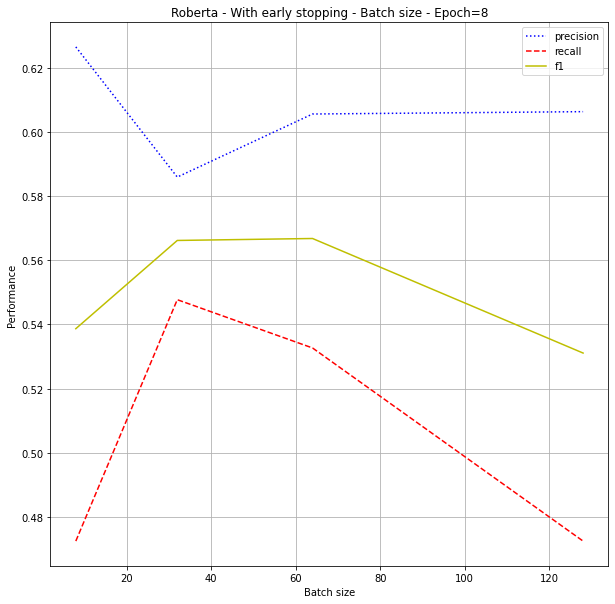

In [56]:
# distilbert
# train_batch_size=32,64,128
plt.figure(figsize=(10, 10))

x = [8,32,64,128]
precision=[0.6266666666666667,0.5860215053763441,0.6057142857142858,0.6064516129032258  ]
recall=[0.4723618090452261,0.5477386934673367,0.5326633165829145,0.4723618090452261  ]
f1=[0.5386819484240688,0.5662337662337663,0.5668449197860963,0.5310734463276836  ]

# 0.6549295774647887,0.46733668341708545,0.5454545454545455
plt.plot( x,precision, "b:", label="precision")
plt.plot( x,recall, "r--", label="recall")
plt.plot( x,f1, "y", label="f1")
plt.xlabel("Batch size")
plt.ylabel("Performance")
plt.title('Roberta - With early stopping - Batch size - Epoch=8')
plt.legend()
plt.grid()

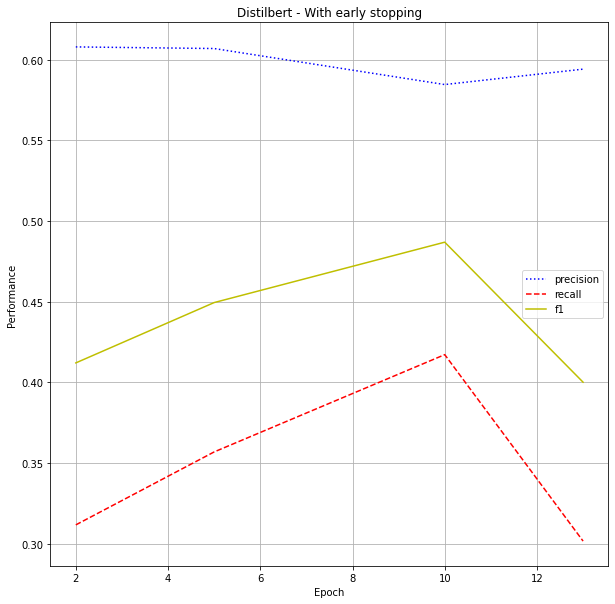

In [52]:
# distilbert
plt.figure(figsize=(10, 10))
x = [2,5, 10,13]
precision=[0.6078431372549019,0.6068376068376068,0.5845070422535211,0.594059405940594]
recall=[0.31155778894472363,0.35678391959798994,0.41708542713567837,0.3015075376884422]
f1=[0.4119601328903654,0.4493670886075949,0.48680351906158353,0.39999999999999997]

plt.plot( x,precision, "b:", label="precision")
plt.plot( x,recall, "r--", label="recall")
plt.plot( x,f1, "y", label="f1")
plt.xlabel("Epoch")
plt.ylabel("Performance")
plt.title('Distilbert - With early stopping')
plt.legend()
plt.grid()

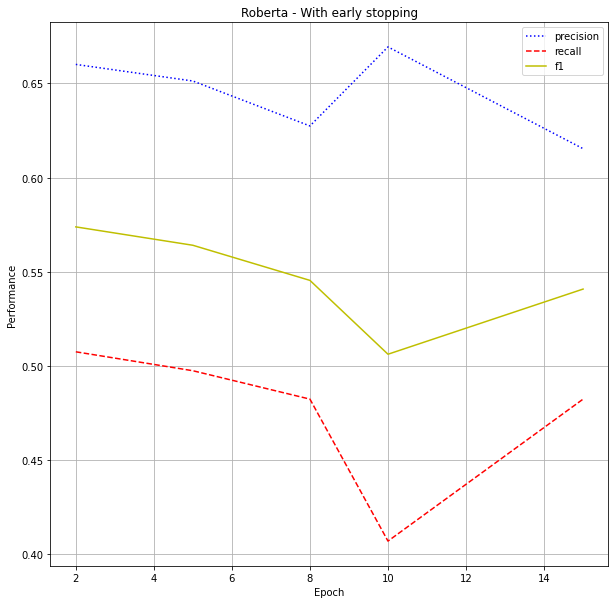

In [53]:
# early stopping
plt.figure(figsize=(10, 10))
x = [2,5,8,10,15]
precision=[0.6601307189542484,0.6513157894736842,0.6274509803921569,0.6694214876033058,0.6153846153846154]
recall=[0.507537688442211,0.49748743718592964,0.4824120603015075,0.40703517587939697,0.4824120603015075]
f1=[0.5738636363636364,0.5641025641025641,0.5454545454545455,0.5062499999999999,0.5408450704225353]

# 0.6549295774647887,0.46733668341708545,0.5454545454545455
plt.plot( x,precision, "b:", label="precision")
plt.plot( x,recall, "r--", label="recall")
plt.plot( x,f1, "y", label="f1")
plt.xlabel("Epoch")
plt.ylabel("Performance")
plt.title('Roberta - With early stopping')
plt.legend()
plt.grid()

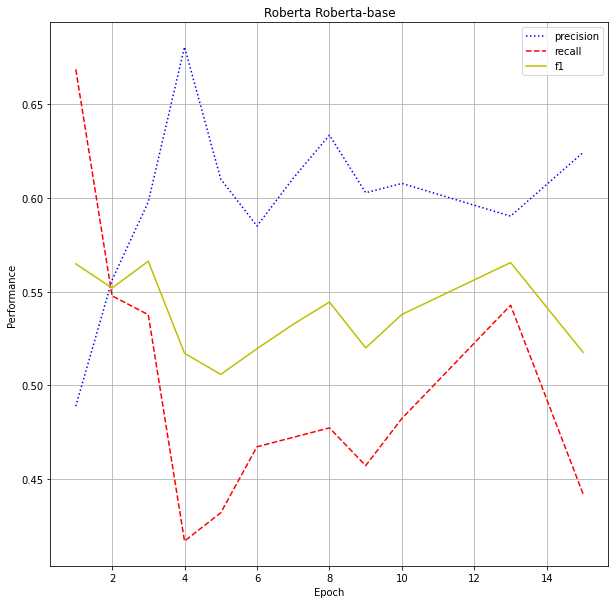

In [54]:
plt.figure(figsize=(10, 10))
x = [1,2,3,4,5,6,7,8,9,10,13,15]
precision=[0.4889705882352941,0.5561224489795918, 0.5977653631284916,0.680327868852459,0.6099290780141844,0.5849056603773585,0.6103896103896104, 0.6333333333333333, 0.6026490066225165, 0.6075949367088608,0.5901639344262295,0.624113475177305]
recall=[0.6683417085427136,0.5477386934673367, 0.5376884422110553,0.41708542713567837, 0.4321608040201005,0.46733668341708545,0.4723618090452261, 0.47738693467336685,0.457286432160804, 0.4824120603015075,0.542713567839196,0.44221105527638194]
f1=[0.5647558386411891,0.5518987341772151, 0.5661375661375662, 0.5171339563862929,0.5058823529411764,0.5195530726256984, 0.5325779036827196, 0.5444126074498568, 0.5199999999999999, 0.5378151260504201,0.5654450261780105,0.5176470588235293]


# 0.6549295774647887,0.46733668341708545,0.5454545454545455
plt.plot( x,precision, "b:", label="precision")
plt.plot( x,recall, "r--", label="recall")
plt.plot( x,f1, "y", label="f1")
plt.xlabel("Epoch")
plt.ylabel("Performance")
plt.title('Roberta Roberta-base')
plt.legend()
plt.grid()

In [ ]:
#This is for xlnet
task1_model_args = ClassificationArgs(num_train_epochs=5, 
                                      no_save=True, 
                                      no_cache=True, 
                                      overwrite_output_dir=True,
                                     train_batch_size=32,
                                     #evaluate_during_training = True,
                                     #evaluate_during_training_steps = 86,
                                     evaluate_during_training_verbose = True,
                                     use_cached_eval_features = True,
                                     #use_early_stopping = True,
                                     early_stopping_delta = 0.01,
                                     early_stopping_metric = "mcc",
                                     early_stopping_metric_minimize = True,
                                     early_stopping_patience = 2)

task1_model = ClassificationModel("xlnet", 
                                  'xlnet-large-cased', 
                                  args = task1_model_args, 
                                  num_labels=2,
                                  weight=[0.25,0.70],
                                  use_cuda=cuda_available)

task1_model.train_model(training_set2[['text', 'label']], eval_df=tedf2[['text', 'label']])

preds_task1,raw = task1_model.predict(tedf2.text.tolist())

preds_task1_bert = [[k] for k in preds_task1]
labels2file(preds_task1_bert, 'task1_res.txt')
labels2file([[k] for k in tedf2.label.values],'task1_ref.txt')

In [ ]:
df_test = pd.read_csv('task4_test.tsv', sep='\t', header=None, engine = 'python')
print(len(df_test))
df_test = df_test.drop(columns = [0])
df_test.columns = ['ID', 'keyword', 'country_code', 'paragraph']

3832


In [ ]:
preds_task4, _ = task1_model.predict(df_test.paragraph.tolist())
labels2file([[k] for k in preds_task4], 'task1.txt')

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/3832 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]